# CelebA Multilabel Image Classification

In [25]:
import datetime
import pandas as pd
import operator
import scipy as sp
import logging
import warnings

import time
import math
import random
import glob

import numpy as np
import argparse

from random import shuffle
import random
import math

from PIL import Image

import os
import sys
import h5py
from glob import glob
import string
import cv2
from PIL import Image
from tqdm import tqdm_notebook
import shutil

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import hamming_loss

from skimage import data
from skimage import color
from skimage import io
import skimage.transform

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from matplotlib.pyplot import imshow,imread,imsave

from subprocess import check_output

# Any results you write to the current directory are saved as output.
from sklearn.model_selection import train_test_split
from pylab import rcParams

from skimage.color import gray2rgb
from skimage import io
from skimage import data
from skimage import color
from skimage import io
import skimage.transform

import warnings
warnings.filterwarnings('ignore')

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import load_model
from keras_tqdm import TQDMNotebookCallback
from keras.models import Sequential
from keras.layers import Dense,LeakyReLU,BatchNormalization
from keras.layers import Dropout
from keras.layers import Flatten,Activation
from keras.constraints import maxnorm
from keras.optimizers import SGD,Adam
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from keras.callbacks import Callback

import zipfile

# Allow image embeding in notebook
%matplotlib inline

## Preprocessing

In [26]:
path_att='../Anno/list_attr_celeba.txt'

def preprocessing(path_to_att_file):
    
    '''
    A function that takes the path to 
    the attibute table and does some preprocessing 
    and return a dataframe and labels
    '''
    dataframe = pd.read_csv(path_to_att_file,delimiter=r"\s+",skiprows=1,index_col=None)

    labels=dataframe.columns.tolist()

    dataframe=dataframe.replace(-1,0)
    
    dataframe=dataframe.reset_index()
    dataframe=dataframe.rename(index=str, columns={"index": "Images"})
    
    return dataframe, labels

df, labels = preprocessing(path_att)

In [11]:
def train_validate_test_split(df, train_percent=.8, validate_percent=.1, seed=None):
    
    np.random.seed(seed)
    # mixes indexes
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

train, dev, test = train_validate_test_split(df)

## Image Batch Generator

In [12]:
def image_batch_generator(df,images_path, batch_size):
    
    '''
    A generator that takes a dataframe (for image names) and
    with a given image path goes to conver images to numpy array over
    batch (chunk by chunk).
    '''

    L = df.shape[0]
    files = df['Images'].tolist()

    #this line is just to make the generator infinite, keras needs that    
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
            
            X= np.array([np.array(skimage.transform.resize(io.imread(os.path.join(images_path,fname))/255., (64, 64))) for fname in files[batch_start:limit]])
            y=df.loc[df["Images"].isin(files[batch_start:limit]), :].drop(['Images'],axis=1).values

            yield (X,y) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size

In [13]:
train.shape,dev.shape,test.shape

((162079, 41), (20259, 41), (20261, 41))

## Sample Training Images

In [14]:
images_path='../img_align_celeba/'

tmp_gen = image_batch_generator(train,images_path,128)
tmp_train_imgs=next(tmp_gen)

In [9]:
tmp_train_imgs[0].shape,tmp_train_imgs[1].shape

((128, 64, 64, 3), (128, 40))

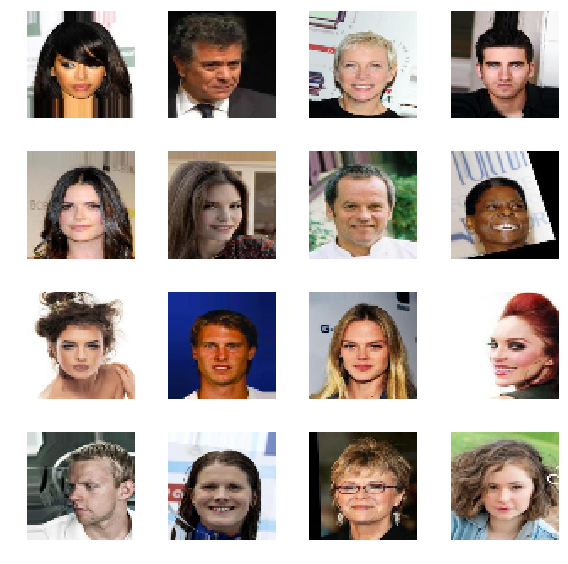

In [11]:
sample_indexes = random.sample(range(tmp_train_imgs[0].shape[0]), 16)
sample_images = [tmp_train_imgs[0][i] for i in sample_indexes]
sample_labels = [tmp_train_imgs[1][i] for i in sample_indexes]

fig = plt.figure(figsize=(8, 8))

for i in range(len(sample_images)):
    plt.subplot(4, 4,1+i)
    plt.axis('off')
    #plt.text(0,0,"Label {0} Class {1}\n".format(le.inverse_transform(sample_labels[i]),i),fontsize=10)
    plt.imshow(sample_images[i])
    
    plt.tight_layout()

## CNN Model 1

In [18]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),padding='same',input_shape=(64, 64, 3)))
model.add(Activation('relu'))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(32,(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(40))
model.add(Activation('sigmoid'))

#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 64, 64, 64)        1792      
_________________________________________________________________
activation_4 (Activation)    (None, 64, 64, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 62, 62, 64)        36928     
_________________________________________________________________
activation_5 (Activation)    (None, 62, 62, 64)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 31, 31, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 31, 31, 128)       73856     
__________

In [19]:
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        
history = LossHistory()

## Callback for early stopping the training
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=2,
                              verbose=0, mode='auto')

## Model Training

In [20]:
batch_size=64
images_path='../img_align_celeba/'

fitted_model=model.fit_generator(image_batch_generator(train,images_path,batch_size),
                                 steps_per_epoch= 200,#int(train.shape[0]/batch_size),
                                 epochs=40,
                                 validation_data=image_batch_generator(dev,images_path,batch_size),
                                 validation_steps=100,#int(dev.shape[0]/batch_size),
                                 callbacks=[TQDMNotebookCallback(leave_inner=True, leave_outer=True), early_stopping, history])

HBox(children=(IntProgress(value=0, description='Training', max=40), HTML(value='')))

HBox(children=(IntProgress(value=0, description='Epoch 0', max=200), HTML(value='')))

Epoch 1/40
200/200 [==============================] - 595s 3s/step - loss: 0.4392 - acc: 0.8055 - val_loss: 0.3569 - val_acc: 0.8506


HBox(children=(IntProgress(value=0, description='Epoch 1', max=200), HTML(value='')))

Epoch 2/40
200/200 [==============================] - 627s 3s/step - loss: 0.3573 - acc: 0.8469 - val_loss: 0.3186 - val_acc: 0.8647


HBox(children=(IntProgress(value=0, description='Epoch 2', max=200), HTML(value='')))

Epoch 3/40
200/200 [==============================] - 601s 3s/step - loss: 0.3316 - acc: 0.8581 - val_loss: 0.2995 - val_acc: 0.8717


HBox(children=(IntProgress(value=0, description='Epoch 3', max=200), HTML(value='')))

Epoch 4/40
200/200 [==============================] - 571s 3s/step - loss: 0.3208 - acc: 0.8622 - val_loss: 0.2932 - val_acc: 0.8741


HBox(children=(IntProgress(value=0, description='Epoch 4', max=200), HTML(value='')))

Epoch 5/40
200/200 [==============================] - 568s 3s/step - loss: 0.3135 - acc: 0.8651 - val_loss: 0.2876 - val_acc: 0.8744


HBox(children=(IntProgress(value=0, description='Epoch 5', max=200), HTML(value='')))

Epoch 6/40
200/200 [==============================] - 570s 3s/step - loss: 0.3090 - acc: 0.8668 - val_loss: 0.2805 - val_acc: 0.8787


HBox(children=(IntProgress(value=0, description='Epoch 6', max=200), HTML(value='')))

Epoch 7/40
200/200 [==============================] - 580s 3s/step - loss: 0.3074 - acc: 0.8674 - val_loss: 0.2827 - val_acc: 0.8771


HBox(children=(IntProgress(value=0, description='Epoch 7', max=200), HTML(value='')))

Epoch 8/40
200/200 [==============================] - 585s 3s/step - loss: 0.3035 - acc: 0.8693 - val_loss: 0.2779 - val_acc: 0.8777


HBox(children=(IntProgress(value=0, description='Epoch 8', max=200), HTML(value='')))

Epoch 9/40
200/200 [==============================] - 590s 3s/step - loss: 0.3023 - acc: 0.8693 - val_loss: 0.2690 - val_acc: 0.8826


HBox(children=(IntProgress(value=0, description='Epoch 9', max=200), HTML(value='')))

Epoch 10/40
200/200 [==============================] - 590s 3s/step - loss: 0.3005 - acc: 0.8699 - val_loss: 0.2713 - val_acc: 0.8812


HBox(children=(IntProgress(value=0, description='Epoch 10', max=200), HTML(value='')))

Epoch 11/40
200/200 [==============================] - 664s 3s/step - loss: 0.2976 - acc: 0.8711 - val_loss: 0.2701 - val_acc: 0.8817


## Validation Curves

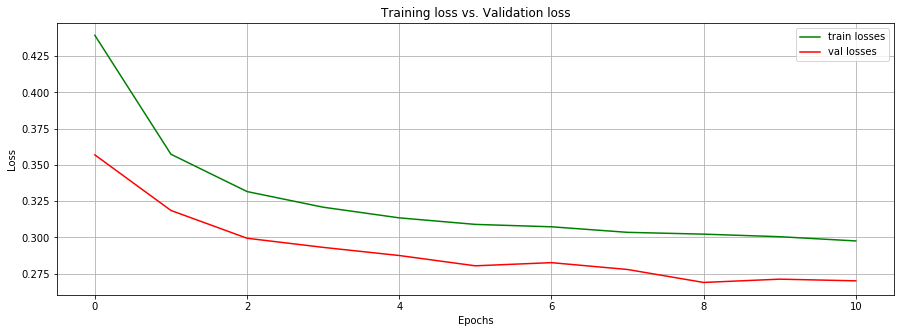

In [23]:
losses, val_losses = history.losses, history.val_losses
fig = plt.figure(figsize=(15, 5))
plt.plot(fitted_model.history['loss'], 'g', label="train losses")
plt.plot(fitted_model.history['val_loss'], 'r', label="val losses")
plt.grid(True)
plt.title('Training loss vs. Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

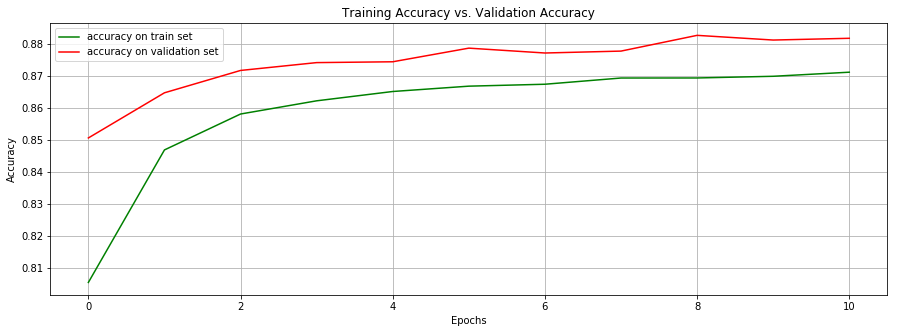

In [24]:
losses, val_losses = history.losses, history.val_losses
fig = plt.figure(figsize=(15, 5))
plt.plot(fitted_model.history['acc'], 'g', label="accuracy on train set")
plt.plot(fitted_model.history['val_acc'], 'r', label="accuracy on validation set")
plt.grid(True)
plt.title('Training Accuracy vs. Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()